In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [2]:
#네이버 영화 리뷰 크롤링 데이터 다운
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")
reviews = pd.read_table('ratings.txt')
display(reviews)

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1
...,...,...,...
199995,8963373,포켓 몬스터 짜가 ㅡㅡ;;,0
199996,3302770,쓰.레.기,0
199997,5458175,완전 사이코영화. 마지막은 더욱더 이 영화의질을 떨어트린다.,0
199998,6908648,왜난 재미없었지 ㅠㅠ 라따뚜이 보고나서 스머프 봐서 그런가 ㅋㅋ,0


In [3]:
# 빠른 토큰화를 위해 데이터셋 크기를 절반으로 줄여주겠습니다
reviews = reviews.sample(n=100000,axis = 0,random_state = 100)
reviews

,id,document,label
180481,10066608,9점대 영화는 아니고 7점 정도 될 영화라 생각하기에 평점 조절,0
8971,7458638,잔 모로의 마력!,1
77027,9764118,왜요 이영화가 뭔 죄가있다고,1
21656,9792714,ㅋㅋ지금 롤러코스터보는데ㅋㅋ땅콩 나오고 욕설 나오고 뭔가 시기가 지금 나왔으면 재미...,1
58303,9769907,버지니아가 데이빗과 클레어를 자유롭게 해주었다.,1
...,...,...,...
76483,274375,"""유산""을 쉽게 생각하는 우리사회사람들을 지적하는 영화",1
76413,2415894,정말 동화속이야기 왠지 상상하게된달까? 재밌게 보았씁니다,1
196175,4753200,흠................ 이건 진짜 아니야!,0
160592,7416398,느와르에 먹칠을 해주었네,0


In [4]:
print('결측치 갯수 확인 \n',reviews.isnull().sum())

결측치 갯수 확인 
 id          0
document    3
label       0
dtype: int64


In [5]:
reviews = reviews.dropna(how = 'any')
print('결측치 갯수 확인 \n',reviews.isnull().sum())

결측치 갯수 확인 
 id          0
document    0
label       0
dtype: int64


In [6]:
print(len(reviews))

99997


In [7]:
# 정규 표현식을 통해 한글 외의 문자를 제거해줍니다
reviews['document'] = reviews['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
display(reviews)

C:\Users\kdo71\AppData\Local\Temp\ipykernel_9288\3194670001.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  reviews['document'] = reviews['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
C:\Users\kdo71\AppData\Local\Temp\ipykernel_9288\3194670001.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['document'] = reviews['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,id,document,label
180481,10066608,점대 영화는 아니고 점 정도 될 영화라 생각하기에 평점 조절,0
8971,7458638,잔 모로의 마력,1
77027,9764118,왜요 이영화가 뭔 죄가있다고,1
21656,9792714,ㅋㅋ지금 롤러코스터보는데ㅋㅋ땅콩 나오고 욕설 나오고 뭔가 시기가 지금 나왔으면 재미...,1
58303,9769907,버지니아가 데이빗과 클레어를 자유롭게 해주었다,1
...,...,...,...
76483,274375,유산을 쉽게 생각하는 우리사회사람들을 지적하는 영화,1
76413,2415894,정말 동화속이야기 왠지 상상하게된달까 재밌게 보았씁니다,1
196175,4753200,흠 이건 진짜 아니야,0
160592,7416398,느와르에 먹칠을 해주었네,0


In [8]:
from tqdm import tqdm

'''
##### TODO 1 #####

분석에 무관할 것 같은 불용어들을 직접 선정해 넣어주세요
저는 주로 데이터 도메인과 너무 직접적인 단어(ex.영화)를 넣거나,
토큰화 찍어보고 쓱쓱 내려본 다음에 눈에 거슬리는 것들을 때려박습니다.
이건 연습이니 아무거나 넣으셔도 상관 없습니다!
'''
stopwords = ['영화', '스토리', '평', '평점',
             '감독', '개봉', '추천'
            ]

file = open('stopwords.txt', encoding="UTF-8")
line = file.readline().strip()
while line:
    stopwords.append(line)
    line = file.readline().strip()
file.close()

# 형태소 분석기 OKT를 사용한 토큰화 작업 (6분 정도 걸려요!)
okt = Okt()

tokenized_data = []
for sentence in tqdm(reviews['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

100%|██████████| 99997/99997 [03:55<00:00, 424.30it/s]


리뷰의 최대 길이 : 65
리뷰의 평균 길이 : 9.834165024950748


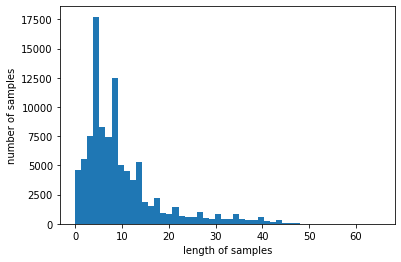

In [9]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [10]:
from gensim.models import Word2Vec

'''
https://radimrehurek.com/gensim/models/word2vec.html
model = Word2Vec(data,                # 리스트 형태의 데이터
                 sg=1,                # 0: CBOW, 1: Skip-gram
                 vector_size=100,     # 벡터 크기
                 window=3,            # 윈도우 크기
                 min_count=3,         # 사용할 단어의 최소 빈도(3회 이하 단어는 무시)
                 workers=4)           # 동시에 처리할 작업 수(코어 수와 비슷하게 설정)
'''

model = Word2Vec(sentences = tokenized_data, vector_size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [11]:
# 앞의 숫자는 임베딩 된 단어의 갯수, 뒤의 숫자는 각 단어벡터의 크기입니다

model.wv.vectors.shape

(11211, 100)

In [12]:
'''
##### TODO 2 #####
model.wv.most_similar(단어)는 argument로 들어간 단어와 가장 유사한 단어를 순서대로 보여줍니다.
print(model.wv.most_similar("")) 에 적당한 인자를 넣어 해당 단어와 가장 유사한 단어를 확인해보세요.
좋아하는 영화배우나 장르를 해도 좋고, 꿀잼 노잼 등과 같은 평가와 관련된 단어도 좋습니다.
'''
print(model.wv.most_similar("범죄"))

[('군국', 0.9139347672462463), ('우월', 0.9110431671142578), ('미스터리', 0.9040275812149048), ('조폭', 0.8976482152938843), ('물의', 0.8898518085479736), ('주의', 0.8895280957221985), ('영국', 0.8824189305305481), ('슬래셔', 0.8795466423034668), ('느와르', 0.8749644160270691), ('계', 0.8745468258857727)]
